# Adapted from

https://github.com/Project-MONAI/tutorials/blob/main/modules/transfer_mmar.ipynb

In [1]:
# !pip install monai
# !python -c "import monai" || pip install -q "monai-weekly[nibabel, lmdb, tqdm]"

In [136]:
import os, sys, shutil, time, pickle, glob
from pathlib import Path

# numpy to SITK conversion
import torch
import numpy     as np
import SimpleITK as sitk

# hardware stats
import GPUtil as GPU

# plot
from helpers.viz import viz_axis, viz_compare_inputs, viz_compare_outputs
from helpers.viz import *

import matplotlib.pyplot as plt

# MONAI
from monai.networks.nets import UNet
from monai.losses import DiceFocalLoss
from monai.metrics import DiceMetric
from monai.inferers import sliding_window_inference
from monai.data import (
    Dataset,
    CacheDataset,
    LMDBDataset,
    DataLoader,
    decollate_batch,
)

from monai.networks.utils import copy_model_state
from monai.optimizers import generate_param_groups

from monai.transforms import (
    AsDiscrete,
    AddChanneld,
    CenterSpatialCropd,
    EnsureChannelFirstd,
    Compose,
    LoadImaged,
    NormalizeIntensityd,
    PadListDataCollate,
    ScaleIntensityRanged,
    Spacingd,
    SpatialPadd,
    Orientationd,
    CropForegroundd,
    RandCropByPosNegLabeld,
    RandAffined,
    RandRotated,
    EnsureType,
    EnsureTyped,
    ToTensord,
)

%matplotlib inline


# Get labels

In [130]:
root = "/home/gologors/data/"

with open(root + 'pitmri/' + 'all_filenames_pt.pkl', 'rb') as f:
    all_filenames_pt = pickle.load(f)

with open(root + 'pitmri/' + 'loni_filenames.pkl', 'rb') as f: 
    loni_filenames = pickle.load(f)
    
# with open(root + 'pitmri/' + 'all_filenames_nii.pkl', 'rb') as f: 
#     all_filenames = pickle.load(f)
    
with open(root + 'pitmri/' + 'las_nii_im_datadict_pt.pkl', 'rb') as f:
     im_datadict_pt = pickle.load(f)

with open(root + 'pitmri/' + 'loni_bboxs_pt.pkl', 'rb') as f:
    loni_bboxs = pickle.load(f)
    
loni_filenames = all_filenames_pt[:len(loni_filenames)]
pit_filenames  = all_filenames_pt[len(loni_filenames):]

print("LONI: ", loni_filenames[0][0])
print("PIT: ", pit_filenames[0][0])

# Split into training/valid and testing 
# adapted from https://github.com/Project-MONAI/tutorials/blob/main/modules/autoencoder_mednist.ipynb

# Split pit filenames

def split(lst, test_frac, valid_frac):

    num_test  = int(len(lst) * test_frac)
    num_valid = int(len(lst) * valid_frac)
    num_train = len(lst) - num_test - num_valid

    train_datadict = [{"im": nii, "lbl":obj} for nii,obj in lst[0:num_train]]
    valid_datadict = [{"im": nii, "lbl":obj} for nii,obj in lst[num_train:num_train+num_valid]]
    test_datadict = [{"im": nii, "lbl": obj} for nii,obj in lst[-num_test:]]
    
    return train_datadict, valid_datadict, test_datadict


pit_train_datadict, pit_valid_datadict, pit_test_datadict    = split(pit_filenames, test_frac=0, valid_frac=0.1) # 50: 45-5-0
loni_train_datadict, loni_valid_datadict, loni_test_datadict = split(loni_filenames, test_frac=0, valid_frac=0.) # 337 all train

train_datadict = pit_train_datadict + loni_train_datadict
valid_datadict = pit_valid_datadict
test_datadict = {}

print(f"total number of images: {len(pit_filenames) + len(loni_filenames)}")
print(f"number of images for training: {len(train_datadict)}")
print(f"number of images for val: {len(valid_datadict)}")
print(f"number of images for testing: {len(test_datadict)}")

# Expand to 2d
def expand_2d(lst):
    twod = []
    
    for d in lst:
        item    = (d["im"],d["lbl"])
        is_loni = ("loni" in d["im"])
        
        # add coronal slices as seperate items
        if is_loni:
            loni_bbox = loni_bboxs[loni_filenames.index(item)]["bbox"]
            start = loni_bbox[2]
            end   = loni_bbox[3]
        else:
            shape = im_datadict[all_filenames_pt.index(item)]["shape"]        
            start = 0
            end   = shape[1]
            
        for i in range(start, end):
            twod.append({"im": d["im"], "lbl": d["lbl"], "i": i})
    return twod
            
train_datadict = expand_2d(train_datadict)
valid_datadict = expand_2d(valid_datadict)
test_datadict = expand_2d(test_datadict)

print(f"total number of images: {len(pit_filenames) + len(loni_filenames)}")
print(f"number of images for training: {len(train_datadict)}")
print(f"number of images for val: {len(valid_datadict)}")
print(f"number of images for testing: {len(test_datadict)}")


LONI:  /home/gologors/data/pitmri/las_pt/loni_im_ABIDE_50136_MRI_MP-RAGE_br_raw_20120830202014457_S165053_I329063.pt
PIT:  /home/gologors/data/pitmri/las_pt/pit_im_1.3.46.670589.11.37169.5.0.8820.2016110101521229038_COR_T1_CLEAR_20161101012852_701.pt
total number of images: 387
number of images for training: 382
number of images for val: 5
number of images for testing: 0
total number of images: 387
number of images for training: 10835
number of images for val: 74
number of images for testing: 0


In [116]:
for d in pit_valid_datadict:
    idx = all_filenames.index((d["im"],d["lbl"]))
    shape = im_datadict[idx]["shape"]
    print(shape)

(336, 7, 336)
(256, 11, 256)
(512, 16, 512)
(512, 20, 512)
(384, 20, 384)


In [71]:
# Shapes

def get_im_data(fn):
    reader = sitk.ImageFileReader()

    reader.SetFileName(fn)
    reader.ReadImageInformation()

    return (reader.GetSize(), reader.GetSpacing())

im_data = [get_im_data(im_fn) for im_fn, seg_fn in all_filenames] # if os.path.basename(im_fn).startswith("pit")]
print(len(im_data))

from statistics import median

def get_med(tuple_lst, i):
    l = [o[i] for o in tuple_lst]
    return median(l), min(l), max(l)

print("Median/Min/Max Size 0: ", get_med([o[0] for o in im_data], 0))
print("Median/Min/Max Size 1: ", get_med([o[0] for o in im_data], 1))
print("Median/Min/Max Size 2: ", get_med([o[0] for o in im_data], 2))

387
Median/Min/Max Size 0:  (176, 102, 576)
Median/Min/Max Size 1:  (256, 7, 480)
Median/Min/Max Size 2:  (256, 102, 640)


In [100]:
# im_datadict = [{"spacing": sp, "shape": shape, "im": all_filenames_pt[i][0], "lbl": all_filenames_pt[i][1]} 
#                for i, (shape, sp) in enumerate(im_data)]
# print(*im_datadict, sep="\n")

{'spacing': (1.0, 1.0, 1.0), 'shape': (208, 256, 176), 'im': '/home/gologors/data/pitmri/las_pt/loni_im_ABIDE_50136_MRI_MP-RAGE_br_raw_20120830202014457_S165053_I329063.pt', 'lbl': '/home/gologors/data/pitmri/las_pt/loni_lbl_ABIDE_50136_MRI_MP-RAGE_br_raw_20120830202014457_S165053_I329063.pt'}
{'spacing': (1.100000023841858, 1.0, 1.0), 'shape': (160, 239, 200), 'im': '/home/gologors/data/pitmri/las_pt/loni_im_ABIDE_50149_MRI_MP-RAGE_br_raw_20120831140403702_S165707_I329753.pt', 'lbl': '/home/gologors/data/pitmri/las_pt/loni_lbl_ABIDE_50149_MRI_MP-RAGE_br_raw_20120831140403702_S165707_I329753.pt'}
{'spacing': (1.0500000715255737, 1.05078125, 1.05078125), 'shape': (176, 256, 256), 'im': '/home/gologors/data/pitmri/las_pt/loni_im_ABIDE_50048_MRI_MP-RAGE_br_raw_20120830153652299_S164384_I328378.pt', 'lbl': '/home/gologors/data/pitmri/las_pt/loni_lbl_ABIDE_50048_MRI_MP-RAGE_br_raw_20120830153652299_S164384_I328378.pt'}
{'spacing': (1.0, 1.0, 1.0), 'shape': (208, 256, 176), 'im': '/home/golo

In [101]:
# # Save
# with open(root + 'pitmri/' + 'las_nii_im_datadict_pt.pkl', 'wb') as f:
#     pickle.dump(im_datadict, f)

In [15]:
print(*enumerate(im_data), sep="\n")

(0, ((208, 256, 176), (1.0, 1.0, 1.0)))
(1, ((160, 239, 200), (1.100000023841858, 1.0, 1.0)))
(2, ((176, 256, 256), (1.0500000715255737, 1.05078125, 1.05078125)))
(3, ((208, 256, 176), (1.0, 1.0, 1.0)))
(4, ((208, 256, 176), (1.0, 1.0, 1.0)))
(5, ((176, 256, 256), (1.0500000715255737, 1.05078125, 1.05078125)))
(6, ((176, 256, 256), (1.0500000715255737, 1.05078125, 1.05078125)))
(7, ((176, 256, 256), (1.0500000715255737, 1.05078125, 1.05078125)))
(8, ((176, 256, 256), (1.0500000715255737, 1.05078125, 1.05078125)))
(9, ((176, 256, 256), (1.0500000715255737, 1.05078125, 1.05078125)))
(10, ((208, 256, 176), (1.0, 1.0, 1.0)))
(11, ((208, 256, 176), (1.0, 1.0, 1.0)))
(12, ((176, 256, 256), (1.0500000715255737, 1.05078125, 1.05078125)))
(13, ((176, 256, 256), (1.0500000715255737, 1.05078125, 1.05078125)))
(14, ((176, 256, 256), (1.0500000715255737, 1.05078125, 1.05078125)))
(15, ((160, 238, 200), (1.100000023841858, 1.0, 1.0)))
(16, ((176, 256, 256), (1.0500000715255737, 1.05078125, 1.0507812

In [46]:
# Viz 139

selected = all_filenames[:5] + all_filenames[-5:]
print(*selected, sep="\n")

datadict = [{"im": im, "lbl":lbl} for im,lbl in selected]


#min_pixdim = (0.2734000086784363, 1.7000000476837158, 0.2734000086784363)
#min_pixdim = (1, 1, 1)

ds = []

for d in datadict:
    d1 = LoadImaged(keys=["im", "lbl"])(d)
    ds.append(d1)
#d2 = Spacingd(keys=["im","lbl"], pixdim=min_pixdim, mode=("bilinear", "nearest"))(d1)

('/home/gologors/data/pitmri/las_nii/loni_im_ABIDE_50136_MRI_MP-RAGE_br_raw_20120830202014457_S165053_I329063.nii', '/home/gologors/data/pitmri/las_nii/loni_lbl_ABIDE_50136_MRI_MP-RAGE_br_raw_20120830202014457_S165053_I329063.nii')
('/home/gologors/data/pitmri/las_nii/loni_im_ABIDE_50149_MRI_MP-RAGE_br_raw_20120831140403702_S165707_I329753.nii', '/home/gologors/data/pitmri/las_nii/loni_lbl_ABIDE_50149_MRI_MP-RAGE_br_raw_20120831140403702_S165707_I329753.nii')
('/home/gologors/data/pitmri/las_nii/loni_im_ABIDE_50048_MRI_MP-RAGE_br_raw_20120830153652299_S164384_I328378.nii', '/home/gologors/data/pitmri/las_nii/loni_lbl_ABIDE_50048_MRI_MP-RAGE_br_raw_20120830153652299_S164384_I328378.nii')
('/home/gologors/data/pitmri/las_nii/loni_im_ABIDE_50129_MRI_MP-RAGE_br_raw_20120830154548944_S164400_I328394.nii', '/home/gologors/data/pitmri/las_nii/loni_lbl_ABIDE_50129_MRI_MP-RAGE_br_raw_20120830154548944_S164400_I328394.nii')
('/home/gologors/data/pitmri/las_nii/loni_im_ABIDE_50109_MRI_MP-RAGE_br_

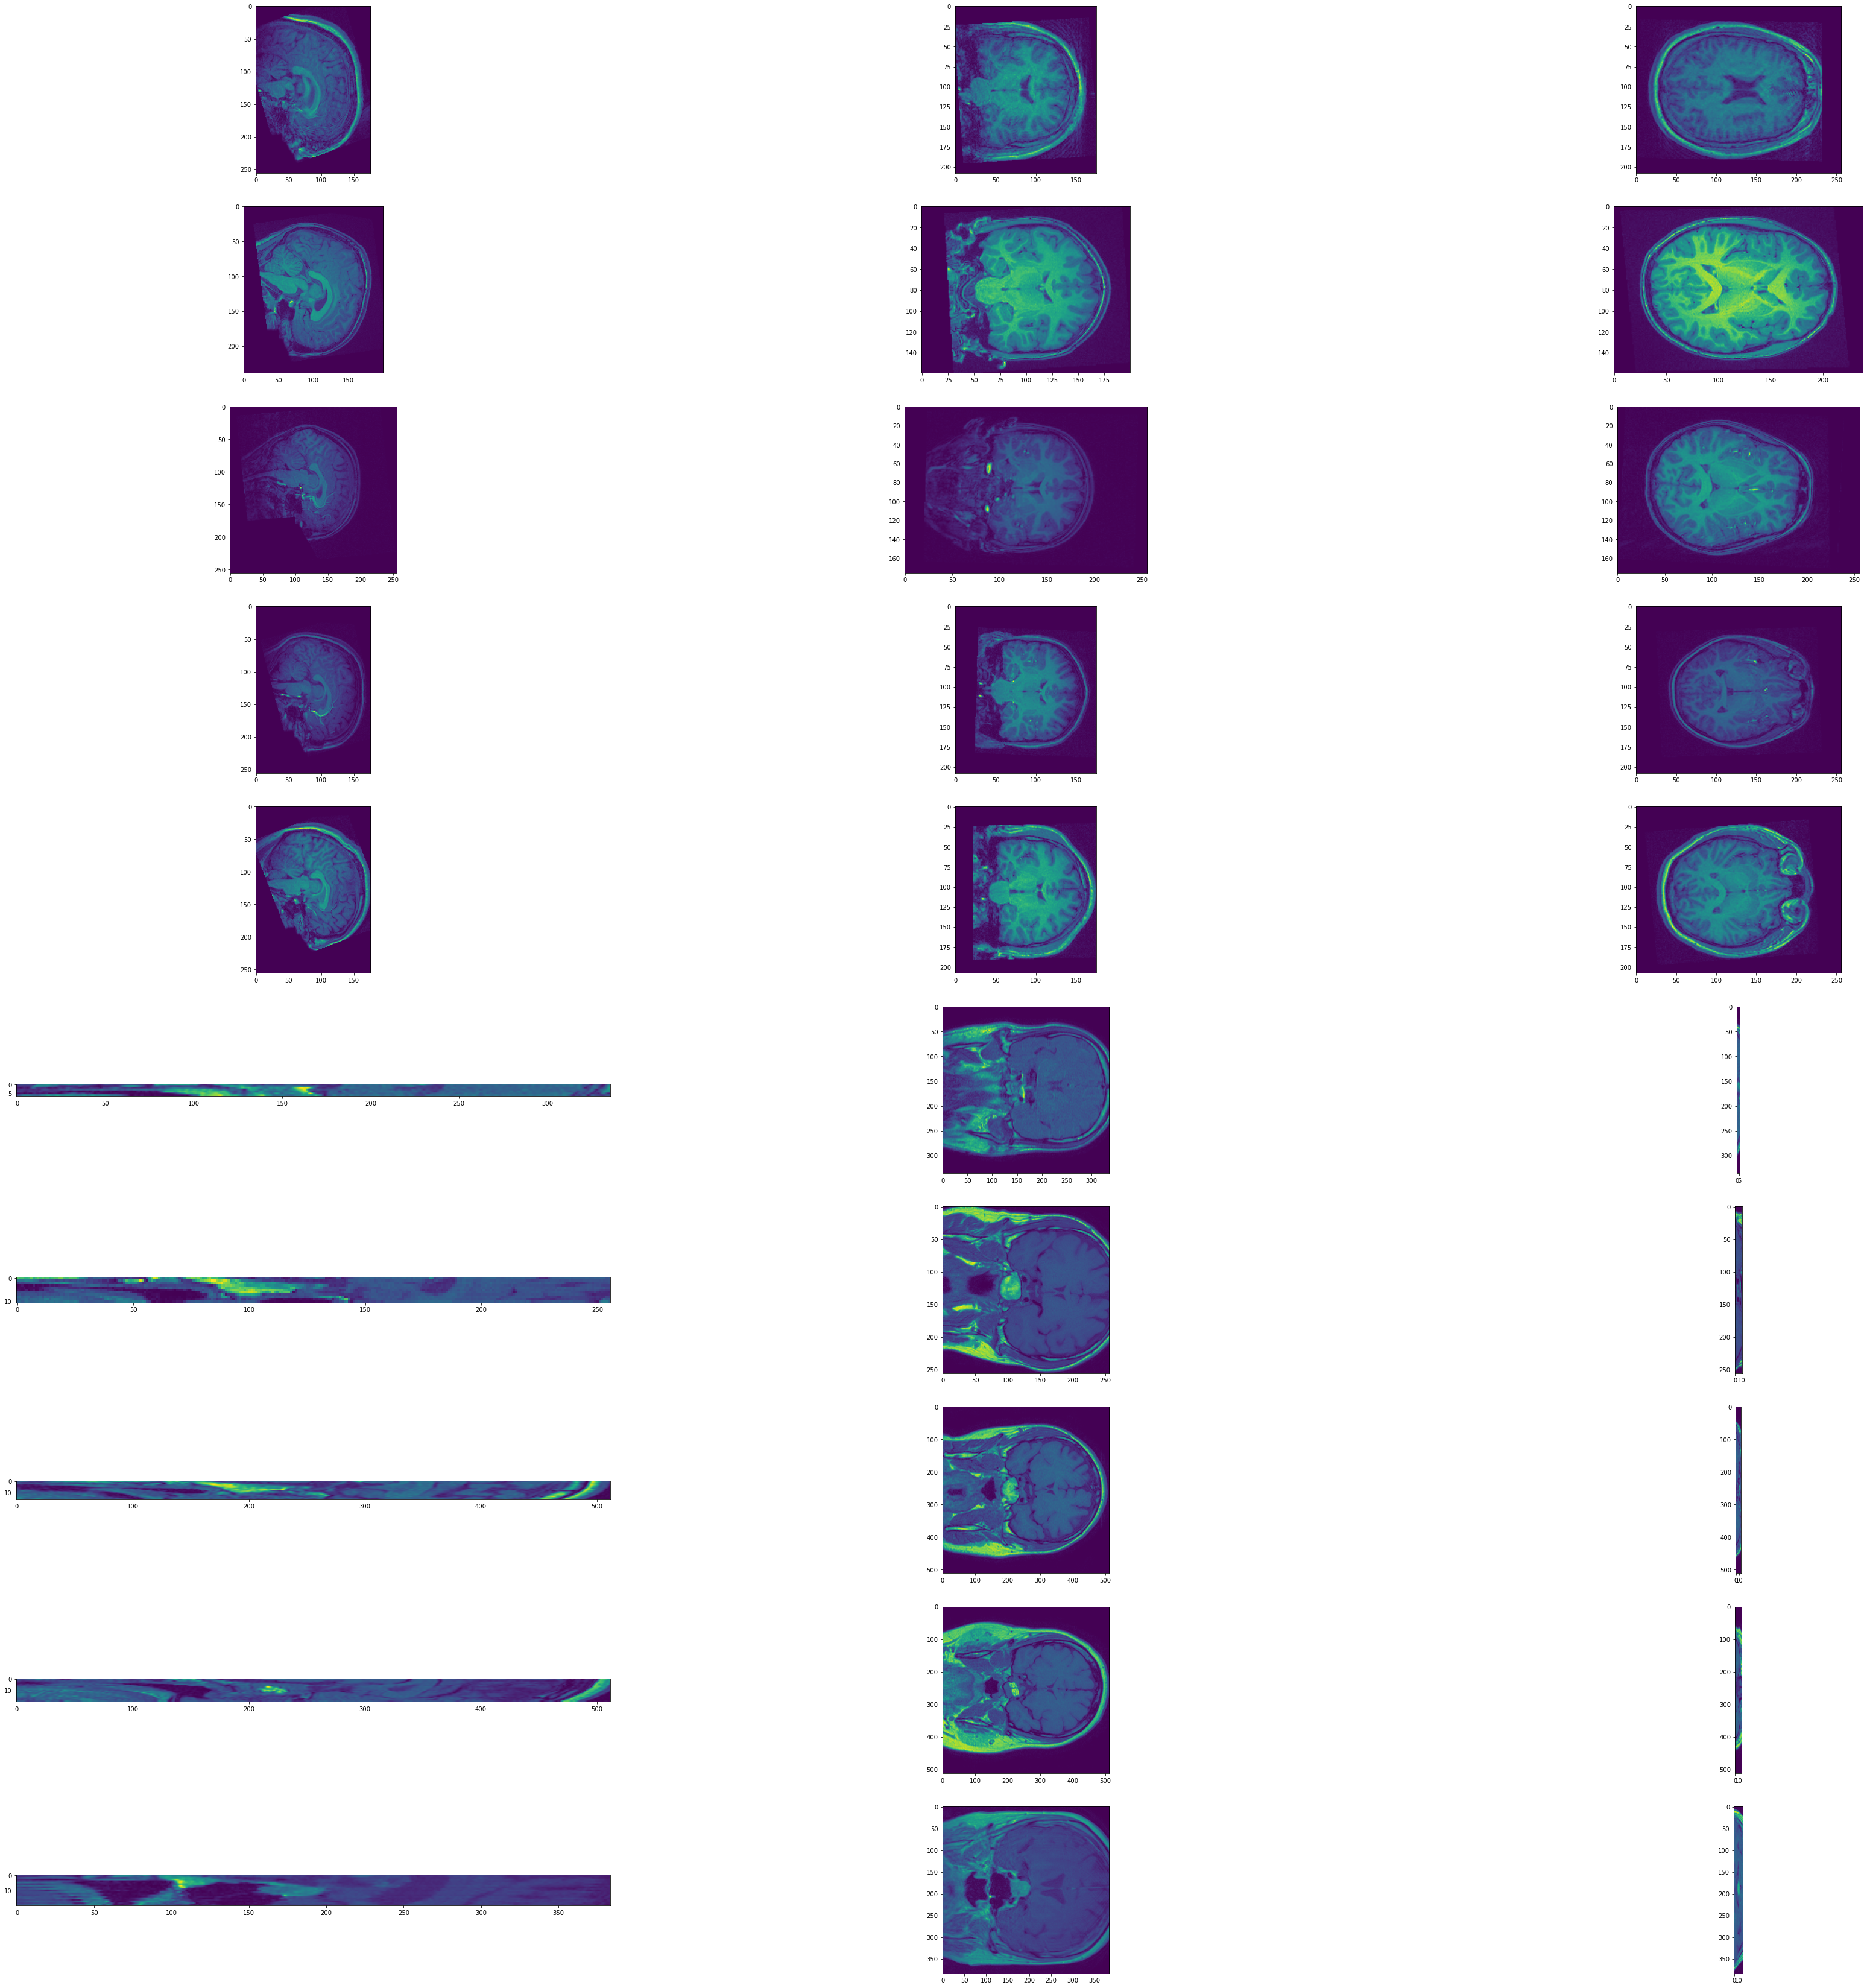

In [47]:
fig, axes = plt.subplots(10, 3, figsize=(60,60))
#fig.suptitle('Horizontally stacked subplots')

for i,ax in enumerate(axes):
    im = ds[i]["im"]
    ax[0].imshow(np.take(im, im.shape[0]//2, axis=0))
    ax[1].imshow(np.take(im, im.shape[1]//2, axis=1))
    ax[2].imshow(np.take(im, im.shape[2]//2, axis=2))

In [11]:
# def print_shapes(all_shapes):
#     print("Shapes of tensors")

#     print("Dim 0")
#     print(min(all_shapes, key=lambda s: s[0]))
#     print(max(all_shapes, key=lambda s: s[0]))

#     print("Dim 1")
#     print(min(all_shapes, key=lambda s: s[1]))
#     print(max(all_shapes, key=lambda s: s[1]))

#     print("Dim 2")
#     print(min(all_shapes, key=lambda s: s[2]))
#     print(max(all_shapes, key=lambda s: s[2]))
    
# print_shapes(all_shapes)

In [173]:
def mask2bbox_pt(mask):
    """Returns bounding box coordinates of binary mask"""
    k = torch.any(torch.any(mask, dim=0), dim=0) # 0 -> 1,2 -> 1 -> 2 left
    j = torch.any(torch.any(mask, dim=0), dim=1) # 0 -> 1,2 -> 2 -> 1 left
    i = torch.any(torch.any(mask, dim=1), dim=1) # 1 -> 0,2 -> 0 -> 0 left
    
    imin, imax = torch.where(i)[0][[0, -1]]
    jmin, jmax = torch.where(j)[0][[0, -1]]
    kmin, kmax = torch.where(k)[0][[0, -1]]
    
    # inclusive indices
    return torch.tensor([imin, imax+1, jmin, jmax+1, kmin, kmax+1])

def sitk2np(obj): return np.swapaxes(sitk.GetArrayFromImage(obj), 0, 2)
def np2sitk(arr): return sitk.GetImageFromArray(np.swapaxes(arr, 0, 2))

def torch2sitk(t): return sitk.GetImageFromArray(torch.transpose(t, 0, 2))
def sitk2torch(o): return torch.transpose(torch.tensor(sitk.GetArrayFromImage(o)), 0, 2)


def load_pt_2d(x):
    d = {}
    im_fn, lbl_fn, i = x["im"], x["lbl"], x["i"]
    
    d["im"]  = torch.load(im_fn)[:,i,:].squeeze()
    d["lbl"] = torch.load(lbl_fn)[:,i,:].squeeze()
    d["i"]   = i

    return d

# loni_bboxs = []
# for im_fn, lbl_fn in loni_filenames:
#     lbl = sitk.ReadImage(lbl_fn, sitk.sitkUInt8)
#     bbox = mask2bbox_pt(sitk2torch(lbl))
#     loni_bboxs.append({"im": im_fn, "lbl": lbl_fn, "bbox": bbox})

In [174]:
# def get_stem_name(fn):
#     basename = os.path.basename(fn)
#     return basename[:basename.index(".nii")]

# get_stem_name(all_filenames[0][0])

In [175]:
# for im_fn, lbl_fn in all_filenames:
#     im  = sitk.ReadImage(im_fn, sitk.sitkFloat32)
#     lbl = sitk.ReadImage(lbl_fn, sitk.sitkUInt8)
    
#     impt = sitk2torch(im)
#     lblpt = sitk2torch(lbl)
    
#     basename_im = get_stem_name(im_fn)
#     basename_lbl = get_stem_name(lbl_fn)
    
#     torch.save(impt, root + 'pitmri/las_pt/' + basename_im + '.pt')
#     torch.save(lblpt, root + 'pitmri/las_pt/' + basename_lbl + '.pt')


In [176]:
# all_filenames_pt = []

# for im_fn, lbl_fn in all_filenames:
 
#     basename_im = get_stem_name(im_fn)
#     basename_lbl = get_stem_name(lbl_fn)
    
#     imfn = root + 'pitmri/las_pt/' + basename_im + '.pt'
#     lblfn = root + 'pitmri/las_pt/' + basename_lbl + '.pt'

#     all_filenames_pt.append((imfn, lblfn))
    
# # Save
# with open(root + 'pitmri/' + 'all_filenames_pt.pkl', 'wb') as f:
#     pickle.dump(all_filenames_pt, f)

In [177]:
# loni_bboxs_pt = [{"im": all_filenames_pt[i][0], "lbl": all_filenames_pt[i][1], "bbox": loni_bboxs[i]["bbox"]} for
#                  i in range(len(loni_filenames))]

In [178]:
# # Save
# with open(root + 'pitmri/' + 'loni_bboxs_pt.pkl', 'wb') as f:
#     pickle.dump(loni_bboxs_pt, f)

In [179]:
# # Shapes
# loni_shapes = []
# for d in loni_train_datadict:
#     item_d = load_pt(d)
#     sh = tuple(item_d["lbl"].shape)
#     loni_shapes.append(sh)
#     print(sh)

In [180]:
# print_shapes(loni_shapes)

# Transforms

In [181]:
largest_sz_pit     = (576, 42, 640)
largest_sz_loni    = (256, 68, 512)

largest_sz         = (640, 640)
center_crop_sz     = (288, 288)

In [182]:
train_datadict[1]

{'im': '/home/gologors/data/pitmri/las_pt/pit_im_1.3.46.670589.11.37169.5.0.8820.2016110101521229038_COR_T1_CLEAR_20161101012852_701.pt',
 'lbl': '/home/gologors/data/pitmri/las_pt/pit_lbl_1.3.46.670589.11.37169.5.0.8820.2016110101521229038_COR_T1_CLEAR_20161101012852_701.pt',
 'i': 1}

In [189]:
load_pt_2d(valid_datadict[0])["im"].shape

torch.Size([336, 336])

In [204]:
# Transforms
from helpers.transforms_simplified import UndoDict

keys=["im", "lbl"]

train_transforms = Compose(
    [
        load_pt_2d,
        NormalizeIntensityd(keys=["im"], nonzero=True, channel_wise=False),
        AddChanneld(keys=keys),
        SpatialPadd(keys=keys, spatial_size=largest_sz, method="symmetric", mode="constant"),
        CenterSpatialCropd(keys=keys, roi_size=center_crop_sz),
        UndoDict(keys=["im", "lbl"])
    ]
)

valid_transforms = train_transforms

In [207]:
check_ds = Dataset(data=valid_datadict, transform=valid_transforms)
check_loader = DataLoader(check_ds, batch_size=2)

torch.Size([1, 1, 288, 288])
image shape: torch.Size([288, 288]), label shape: torch.Size([288, 288])


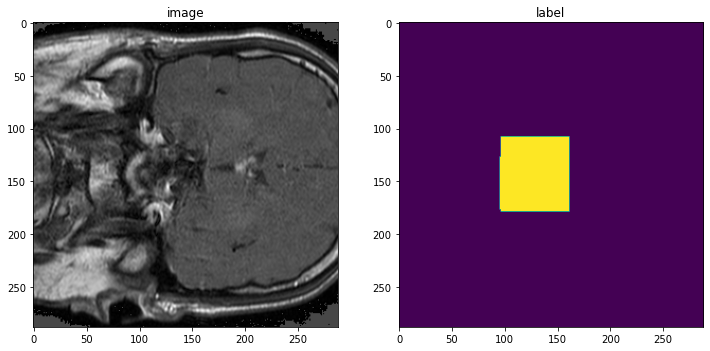

torch.Size([1, 1, 288, 288])
image shape: torch.Size([288, 288]), label shape: torch.Size([288, 288])


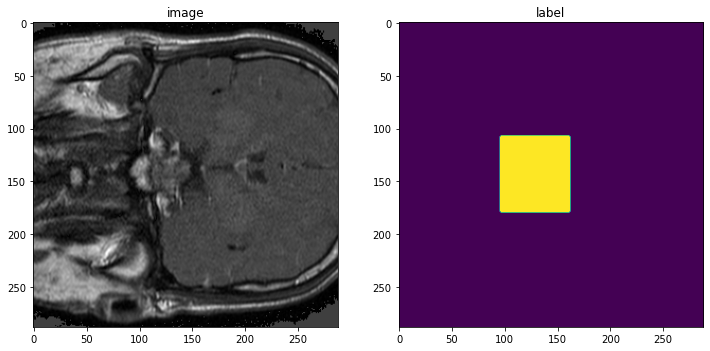

torch.Size([1, 1, 288, 288])
image shape: torch.Size([288, 288]), label shape: torch.Size([288, 288])


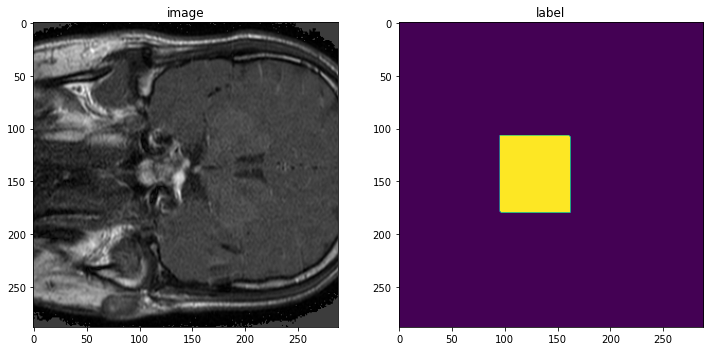

In [208]:
count_ims = 0
for check_data in check_loader:
    print(check_data[0].shape)
    image, label = check_data[0][0][0], check_data[1][0][0] #(check_data["im"][0][0], check_data["lbl"][0][0])
    print(f"image shape: {image.shape}, label shape: {label.shape}")
    #plot the slice [:, :, 21]
    plt.figure("check", (12, 6))
    plt.subplot(1, 2, 1)
    plt.title("image")
    plt.imshow(image, cmap="gray")
    plt.subplot(1, 2, 2)
    plt.title("label")
    plt.imshow(label)
    plt.show()
    
    count_ims += 1
    
    if count_ims == 3:
        break

In [209]:
# Fastai + distributed training
from fastai              import *
from fastai.torch_basics import *
from fastai.basics       import *
from fastai.distributed  import *
from fastai.callback.all import SaveModelCallback, CSVLogger, ProgressCallback

# clear cache
torch.cuda.empty_cache()

from helpers.general import print_hardware_stats
print_hardware_stats()

#GPU = 1, #CPU = 16
GPU NVIDIA TITAN V       RAM Free: 12062MB | Used: 4MB | Util   0% | Total 12066MB


In [237]:
bs = 50

train_dl = TfmdDL(train_datadict, after_item=train_transforms, after_batch=[], bs=bs)
val_dl   = TfmdDL(valid_datadict,   after_item=valid_transforms,   after_batch=[], bs=bs)


dls = DataLoaders(train_dl, val_dl)
dls = dls.cuda()

In [238]:
# PRETRAINED = False

# if PRETRAINED:
#      unet_path = f"/home/gologors/pitmri/PituitaryGenerator/unet/model.pth"
#      checkpoint = torch.load(unet_path)

In [239]:
# print(checkpoint.keys())
# print(checkpoint["opt"].keys())

In [240]:
# UNET model

# 5 layer network with simple convolution/normalization/dropout/activation blocks defining the layers
model = UNet(
    spatial_dims=2,
    in_channels=1,
    out_channels=2,
    channels=(4, 8, 16, 32, 64),
    strides=(2, 2, 2, 2),
)

# model = UNet(
#             dimensions=3,
#             in_channels=1,
#             out_channels=2,
#             channels=(16, 32, 64, 128, 256),
#             strides=(2, 2, 2, 2),
#             num_res_units=2,
#             dropout=0.0,
#         )

In [241]:
# # copy all the pretrained weights except for variables whose name matches "model.0.conv.unit0"
# pretrained_dict, updated_keys, unchanged_keys = copy_model_state(
#     model, checkpoint["model"])

# print("num. var. using the pretrained", len(updated_keys), ", random init", len(unchanged_keys), "variables.")
# model.load_state_dict(pretrained_dict)

# print([x[0] for x in model.named_parameters()])
# print(unchanged_keys)

# # # copy all the pretrained weights except for variables whose name matches "model.0.conv.unit0"
# # pretrained_dict, updated_keys, unchanged_keys = copy_model_state(
# #     model, checkpoint["model"], exclude_vars="model.0.conv.unit0")
# # print("num. var. using the pretrained", len(updated_keys), ", random init", len(unchanged_keys), "variables.")
# # model.load_state_dict(pretrained_dict)

# # print([x[0] for x in model.named_parameters()])
# # print(unchanged_keys)

# # # stop gradients for the pretrained weights
# # for x in model.named_parameters():
# #     if x[0] in updated_keys:
# #         x[1].requires_grad = False
# # params = generate_param_groups(
# #     network=model,
# #     layer_matches=[lambda x: x[0] in updated_keys],
# #     match_types=["filter"],
# #     lr_values=[1e-4],
# #     include_others=False
# # )

In [242]:
from fastai.vision.all import *

In [243]:
# # check
# print("Check")
# b = dls.one_batch()
# xb,yb = b #b["image"], b["label"]
# print(f"Batch: {len(b)}. xb: {xb.shape}, yb: {yb.shape}")
# predb = learn.model(xb)
# print(f"Pred batch: {predb.shape}")
# loss = loss_fn(predb, yb)
# print(f"Loss: {loss}")

In [244]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device = ", device)

model = model.to(device)

Device =  cuda:0


In [245]:
from helpers.time import get_time_id

time_id = get_time_id()

print(time_id)

1653573207_Thu_May_26_2022_hr_09_min_53


In [246]:
model_src = f"/home/gologors/data/saved_models/finetune_learning_unet/fastai/unet2d/" + time_id
fig_src   = f"{model_src}/figs"
Path(fig_src).mkdir(parents=True, exist_ok=True)

In [247]:
# 2d

loss_fn = dice_loss

In [248]:
# cbs
cbs = [
    Recorder(train_metrics=True), # False
    SaveModelCallback(monitor='valid_dice_score', with_opt=True), 
    CSVLogger(fname=f"{fig_src}/history.csv")
]

# learner
learn = Learner(dls   = dls, \
                model     = model, \
                loss_func = loss_fn, \
                metrics   = dice_score, \
                model_dir = model_src, \
                cbs       = [])

# remove post-recorder, add new cbs, to GPU
learn.remove_cbs(learn.cbs[1:])
learn.add_cb(ProgressCallback())
learn.add_cbs(cbs)
learn.model = learn.model.cuda()

In [249]:
# check
print("Check")
b = dls.one_batch()
xb,yb = b #b["image"], b["label"]
print(f"Batch: {len(b)}. xb: {xb.shape}, yb: {yb.shape}")
predb = learn.model(xb)
print(f"Pred batch: {predb.shape}")
loss = loss_fn(predb, yb)
print(f"Loss: {loss}")

Check
Batch: 2. xb: torch.Size([50, 1, 288, 288]), yb: torch.Size([50, 1, 288, 288])
Pred batch: torch.Size([50, 2, 288, 288])
Loss: 0.8542703986167908


In [ ]:
learn.fit_one_cycle(60, 3e-3, wd=1e-4)

Better model found at epoch 0 with valid_dice_score value: 0.16980388760566711.
Better model found at epoch 1 with valid_dice_score value: 0.17183002829551697.


# Plot Loss and Metric

In [ ]:
@delegates(subplots)
def save_plot_metrics(self: Recorder, nrows=None, ncols=None, figsize=None, **kwargs):
    metrics = np.stack(self.values)
    # 'train_loss', 'train_dice_score', 'valid_loss', 'valid_dice_score'
    names = self.metric_names[1:-1]
    print("Metric names: ", names)
    
    names_train = [n for n in names if n.startswith("train")]
    n = len(names_train)
    if nrows is None and ncols is None:
        nrows = int(math.sqrt(n))
        ncols = int(np.ceil(n / nrows))
    elif nrows is None: nrows = int(np.ceil(n / ncols))
    elif ncols is None: ncols = int(np.ceil(n / nrows))
    figsize = (ncols * 6, nrows * 4)
    fig, axs = subplots(nrows, ncols, figsize=figsize)
    for i, ax in enumerate(axs):
        name = names_train[i]
        n = name[name.index("_")+1:]
        valid_name = f"valid_{n}"
        valid_idx = names.index(valid_name)
        print(i, valid_idx, name, valid_name)
        ax.plot(metrics[:, i], color='#1f77b4',  label='train')
        ax.plot(metrics[:, valid_idx], color = '#ff7f0e', label='valid')
        ax.set_title(n)
        ax.legend(loc='best')
    #plt.show()
    plt.savefig(f'{fig_src}/metrics.png', bbox_inches='tight')
    plt.close()

In [ ]:
save_plot_metrics(learn.recorder)

image shape: torch.Size([288, 288, 96]), label shape: torch.Size([288, 288, 96])


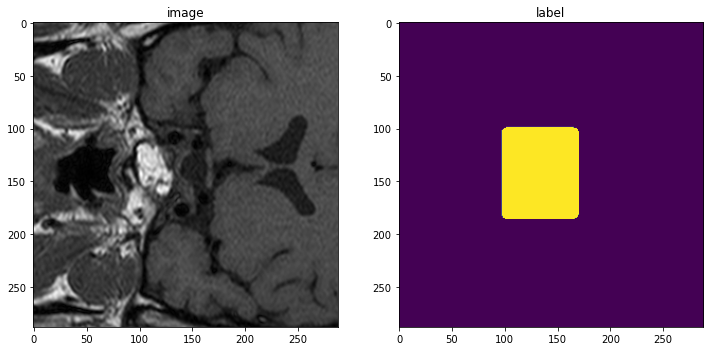

image shape: torch.Size([288, 288, 96]), label shape: torch.Size([288, 288, 96])


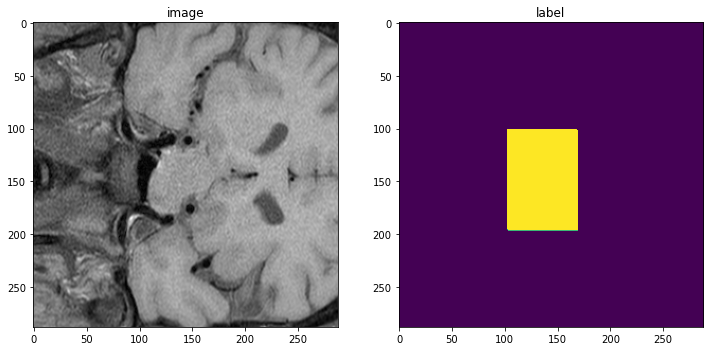

image shape: torch.Size([288, 288, 96]), label shape: torch.Size([288, 288, 96])


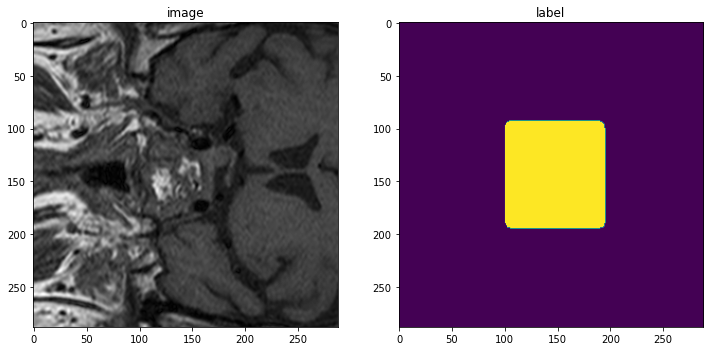

In [35]:
# Transforms

train_transforms = Compose(
    [
        load_pt,
        AddChanneld(keys=["im", "lbl"]),
        SpatialPadd(keys=["im", "lbl"], spatial_size=largest_sz, method="symmetric", mode="constant"),
        CenterSpatialCropd(keys=["im", "lbl"], roi_size=center_crop_sz),
    ]
)

valid_transforms = train_transforms

valid_ds = Dataset(data=pit_valid_datadict, transform=valid_transforms)
valid_loader = DataLoader(valid_ds, batch_size=1)

count_ims = 0
for check_data in valid_loader:
    image, label = (check_data["im"][0][0], check_data["lbl"][0][0])
    print(f"image shape: {image.shape}, label shape: {label.shape}")
    # plot the slice [:, :, 21]
    plt.figure("check", (12, 6))
    plt.subplot(1, 2, 1)
    plt.title("image")
    plt.imshow(image[:, :, center_crop_sz[1]//2], cmap="gray")
    plt.subplot(1, 2, 2)
    plt.title("label")
    plt.imshow(label[:, :, center_crop_sz[1]//2])
    plt.show()
    
    count_ims += 1
    
    if count_ims == 6:
        break

valid_loader = DataLoader(valid_ds, batch_size=2, shuffle=True, num_workers=2)

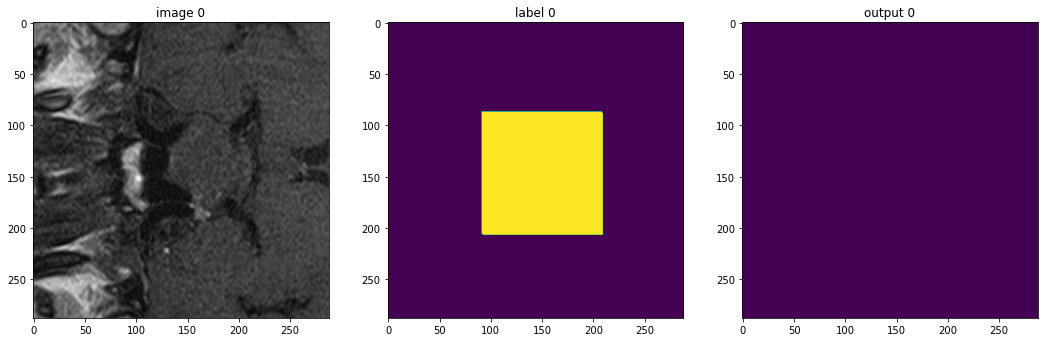

In [37]:
from helpers.viz import *



# UNET model
model1 = UNet(
                    dimensions=3,
                    in_channels=1,
                    out_channels=2,
                    channels=(16, 32, 64, 128, 256),
                    strides=(2, 2, 2, 2),
                    num_res_units=2,
                    dropout=0.0,
                )

save_model_dir = "home/gologors/data/saved_models/transfer_learning_unet/fastai/1653509451_Wed_May_25_2022_hr_16_min_10"

# model.load_state_dict(torch.load(
#     os.path.join(save_model_dir, "best_metric_model.pth")))

model.eval()

with torch.no_grad():
    for i, val_data in enumerate(valid_loader):
        val_inputs, val_labels = (
            val_data["im"].to(device),
            val_data["lbl"].to(device),
        )
        val_outputs = model(val_inputs)
        # plot the slice [:, :, 80]
        plt.figure("check", (18, 6))
        plt.subplot(1, 3, 1)
        plt.title(f"image {i}")
        plt.imshow(val_data["im"][0, 0, :, :, center_crop_sz[2]//2], cmap="gray")
        plt.subplot(1, 3, 2)
        plt.title(f"label {i}")
        plt.imshow(val_data["lbl"][0, 0, :, :, center_crop_sz[2]//2])
        plt.subplot(1, 3, 3)
        plt.title(f"output {i}")
        plt.imshow(torch.argmax(
            val_outputs, dim=1).detach().cpu()[0, :, :, 80])
        plt.show()
        if i == 0:
            break

In [38]:
viz_compare_outputs??

In [39]:
val_outputs.shape

torch.Size([2, 2, 288, 288, 96])

In [40]:
val_inputs.shape

torch.Size([2, 1, 288, 288, 96])

In [50]:
val_inputs[0].cpu().numpy().shape

(1, 288, 288, 96)

Pred: 
Bbox coords: (0, 2, 39) to (288, 288, 57). Size: 288, 286, 18.
Bounding box coord: from location (2, 39) of slice 0 to location (288, 57) of slice 288.
GT: 
Bbox coords: (87, 91, 41) to (207, 209, 55). Size: 120, 118, 14.
Bounding box coord: from location (91, 41) of slice 87 to location (209, 55) of slice 207.
Union: 
Bbox coords: (0, 2, 39) to (288, 288, 57). Size: 288, 286, 18.
Bounding box coord: from location (2, 39) of slice 0 to location (288, 57) of slice 288.
hi
120 5
True opt


KeyboardInterrupt: 

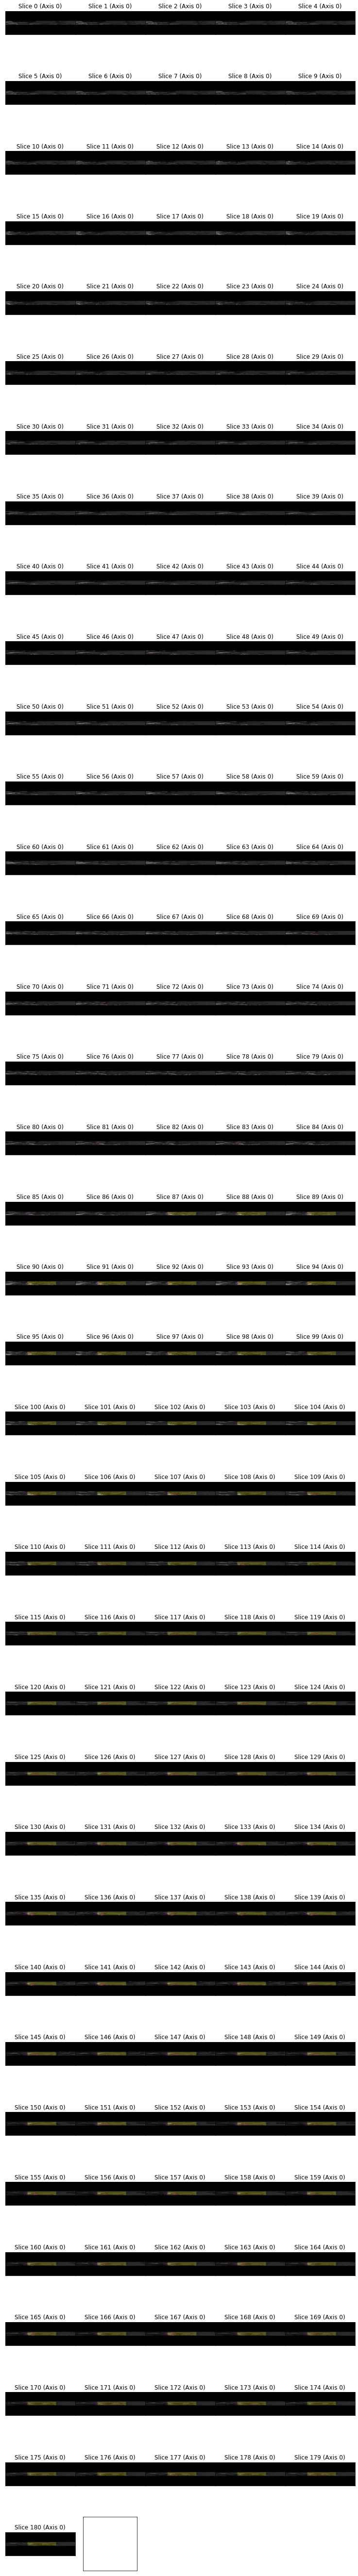

In [52]:
viz_compare_outputs(val_inputs[0].cpu().squeeze(), val_labels[0].cpu().squeeze(), val_outputs[0].cpu().squeeze())

In [ ]:
viz_compare_outputs??

In [ ]:
learn.unfreeze()

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(50, lr_max=slice(1e-4,1e-2))

In [ ]:
learn.metric_names

In [ ]:
model.load_state_dict(torch.load(
    os.path.join(save_model_dir, "best_metric_model.pth")))
model.eval()

with torch.no_grad():
    for i, val_data in enumerate(val_loader):
        roi_size = (160, 160, 160)
        sw_batch_size = 4
        val_outputs = sliding_window_inference(
            val_data["image"].to(device), roi_size, sw_batch_size, model
        )
        # plot the slice [:, :, 80]
        plt.figure("check", (18, 6))
        plt.subplot(1, 3, 1)
        plt.title(f"image {i}")
        plt.imshow(val_data["image"][0, 0, :, :, 80], cmap="gray")
        plt.subplot(1, 3, 2)
        plt.title(f"label {i}")
        plt.imshow(val_data["label"][0, 0, :, :, 80])
        plt.subplot(1, 3, 3)
        plt.title(f"output {i}")
        plt.imshow(torch.argmax(
            val_outputs, dim=1).detach().cpu()[0, :, :, 80])
        plt.show()
        if i == 2:
            break